# Dynamic Bayesian Model - Sleep and Hormone interaction


In this notebook I intend to test the `pgmpy` toolbox to creat a Dynamic Bayesian Model to infere the interactions between sleep stages and hormone, in this case either Cortisol or Growth Hormone, interactions. 

Ideally, this DBN would have t=23 and 5 latency sleep stages as initial conditions.

In [35]:
# Loading required libraries
from matplotlib import pyplot as plt
from matplotlib import colors 
import networkx as nx
import pgmpy
from pgmpy.inference import VariableElimination #module needed for drawing inferences
from pgmpy.models import DynamicBayesianNetwork as DBN #module needed for creating model
from pgmpy.factors.discrete import TabularCPD
import sys 
%matplotlib inline

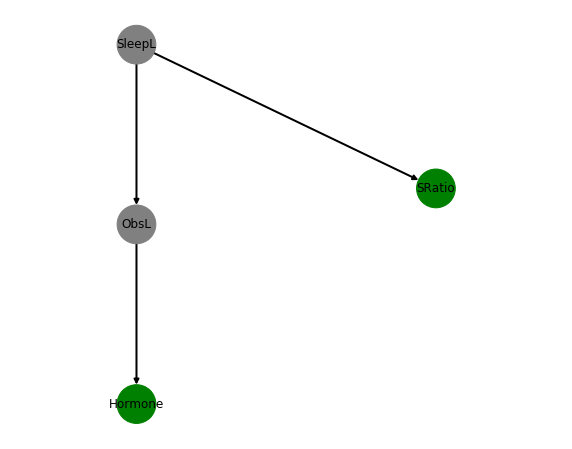

In [39]:
# Creating and visualising the DAG of the DBN model

g = nx.DiGraph()
g.add_node("SleepL", attrs={"coords": (1., 6), "display_form": r"$Sleep$", "observed": False, "color": colors.to_rgb("grey")})
g.add_node("SRatio", attrs={"coords": (1.1, 5.2), "display_form": r"$SRatio$", "observed": True, "color": colors.to_rgb("green")})
g.add_node("ObsL", attrs={"coords": (1, 5.0), "display_form": r"$Obs$", "observed": False, "color": colors.to_rgb("grey")})
g.add_node("Hormone", attrs={"coords": (1., 4.0), "display_form": r"$Hormone$", "observed": True, "color": colors.to_rgb("green")})

g.add_edge("SleepL", "SRatio")  #add link from latent Sleep node to observed SRatio (sleep ratio) node 
g.add_edge("SleepL", "ObsL")  #add link from latent Sleep node to latent observation node 
g.add_edge("ObsL", "Hormone")   #add link from latent observation node to observed Hormone node 

fig, axis = plt.subplots(figsize=(10, 8))
axis.set_axis_off()
axis.grid()
nx.draw_networkx(g, pos={item: g.node[item]["attrs"]["coords"] for item in g.nodes()},  
                 ax=axis,node_size=1500,
                 node_color=[g.node[item]["attrs"]["color"] for item in g.nodes()],
                 width = 2.0) 
mapping={"SleepL":"A"}
g=nx.relabel_nodes(g,mapping,copy=False)

In [41]:
# DBN implementation for t and t+1 only

hormone_DBN= DBN() #create empty DBN structure

#Create graph for time slice t
hormone_DBN.add_edges_from([(('SleepL', 0),('SRatio', 0))]) 
hormone_DBN.add_edges_from([(('SleepL', 0),('ObsL', 0))]) 
hormone_DBN.add_edges_from([(('ObsL', 0),('Hormone', 0))])

#Create graph for time slice t+1
hormone_DBN.add_edges_from([(('SleepL', 1),('SRatio', 1))])
hormone_DBN.add_edges_from([(('SleepL', 1),('ObsL', 1))])
hormone_DBN.add_edges_from([(('ObsL', 1),('Hormone', 1))])
#hormone_DBN.add_edge(('SleepL', 1),('ObsL', 0)) Not possible to create backward nodes

#connect time slice t with time slice t+1
hormone_DBN.add_edges_from([(('SleepL', 0),('SleepL', 1))])
hormone_DBN.add_edges_from([(('SRatio', 0),('ObsL', 1))])

#define CPDs for all of the nodes 
SleepL_cpd = TabularCPD(('SleepL',0),2,[[0.0, 1.0]]) #the node has two possible states: clear(0) or cloudy(1)
SRatio_cpd = TabularCPD(('SRatio',0),2,[[1.0, 0.0],[0.0, 1.0]],evidence=[('SleepL',0)], evidence_card=[2]) 
ObsL_cpd   = TabularCPD(('ObsL',0),  2,[[1.0, 0.0],[0.0, 1.0]],evidence=[('SleepL',0)], evidence_card=[2]) #the node has 2 possible states: clear or rainy
Hormone_cpd= TabularCPD(('Hormone',0),2,[[1.0, 0.0, 0.0, 1.0]],evidence=[('ObsL',0)], evidence_card=[2]) 

SleepL2_cpd = TabularCPD(('SleepL',1),2,[[1.0, 0.0, 0.0, 1.0]],evidence=[('SleepL',0)], evidence_card=[2]) #the node has 2 possible states: clear or rainy
SRatio2_cpd = TabularCPD(('SRatio',1),2,[[1.0, 0.0],[0.0, 1.0]],evidence=[('SleepL',1)], evidence_card=[2]) 
ObsL2_cpd   = TabularCPD(('ObsL',1),2,[[1.0, 0.0, 1.0, 0.0],[0.0, 1.0, 0.0, 1.0]],evidence=[('SRatio',0),('SleepL',1)], evidence_card=[2,2]) 
Hormone2_cpd= TabularCPD(('Hormone',1),2,[[1.0, 0.0, 0.0, 1.0]],evidence=[('ObsL',1)], evidence_card=[2]) 

hormone_DBN.add_cpds(SleepL_cpd,SRatio_cpd,ObsL_cpd,Hormone_cpd,SleepL2_cpd,SRatio2_cpd,ObsL2_cpd,Hormone2_cpd) #add all CPDs


In [25]:
# Example inference - not valide with the evidence provided above
print(ObsL2_cpd)

+----------------+------------------+------------------+------------------+------------------+
| ('SRatio', 0)  | ('SRatio', 0)(0) | ('SRatio', 0)(0) | ('SRatio', 0)(1) | ('SRatio', 0)(1) |
+----------------+------------------+------------------+------------------+------------------+
| ('SleepL', 1)  | ('SleepL', 1)(0) | ('SleepL', 1)(1) | ('SleepL', 1)(0) | ('SleepL', 1)(1) |
+----------------+------------------+------------------+------------------+------------------+
| ('ObsL', 1)(0) | 1.0              | 0.0              | 1.0              | 0.0              |
+----------------+------------------+------------------+------------------+------------------+
| ('ObsL', 1)(1) | 0.0              | 1.0              | 0.0              | 1.0              |
+----------------+------------------+------------------+------------------+------------------+
